In [1]:
# sumber: https://keras.io/examples/vision/object_detection_using_vision_transformer/

# Memuat database dan library




In [17]:
!pip install roboflow

#Ubah kode ini ke link yang Anda dapat dari https://universe.roboflow.com/rb-jmvya/screw-detector-qk4wu/dataset/3, pilih dataset tipe COCO
#Kemudian pasang API key Roboflow, didapat dari https://docs.roboflow.com/developer/authentication/find-your-roboflow-api-key (memerlukan daftar), ke Secret dari notebook ini (gambar kunci) dan beri nama secret baru "ROBOFLOW_API_KEY" dan berikan akses
from roboflow import Roboflow
rf = Roboflow(api_key="(dapatkan dari link diatas)")
project = rf.workspace("rb-jmvya").project("screw-detector-qk4wu")
version = project.version(3)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...


In [3]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]


import numpy as np
import keras
from keras import layers
from keras import ops
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy.io
import shutil

# Memuat gambar-gambar dalam database

In [4]:
import os

path_to_dataset = "./screw-detector-3"

path_train_images = os.path.join(path_to_dataset, "train")
path_valid_images = os.path.join(path_to_dataset, "valid")
path_test_images = os.path.join(path_to_dataset, "test")


image_size = 224

images, targets = [], []

def load_dataset_from_directory(image_dir):
    images = []
    targets = []
    image_paths = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f)) and f.endswith(('.jpg', '.jpeg', '.png'))]
    image_paths.sort()

    for image_name in image_paths:
        image_path = os.path.join(image_dir, image_name)

        dummy_annotation = (0.1, 0.1, 0.9, 0.9)

        image = keras.utils.load_img(image_path)
        (w, h) = image.size[:2]

        image = image.resize((image_size, image_size))

        images.append(keras.utils.img_to_array(image))
        targets.append(dummy_annotation)

    return np.asarray(images), np.asarray(targets)

x_train, y_train = load_dataset_from_directory(path_train_images)
x_valid, y_valid = load_dataset_from_directory(path_valid_images)
x_test, y_test = load_dataset_from_directory(path_test_images)

print(f"Training images: {len(x_train)}")
print(f"Validation images: {len(x_valid)}")
print(f"Test images: {len(x_test)}")

Training images: 8658
Validation images: 308
Test images: 119


In [5]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [6]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


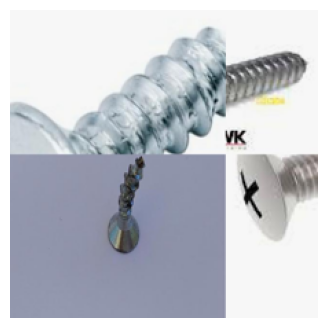

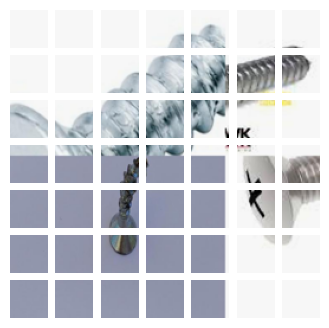

In [7]:
patch_size = 32

plt.figure(figsize=(4, 4))
plt.imshow(x_train[0].astype("uint8"))
plt.axis("off")

patches = Patches(patch_size)(np.expand_dims(x_train[0], axis=0))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

In [8]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

In [9]:
def create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
):
    inputs = keras.Input(shape=input_shape)
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)

    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

    bounding_box = layers.Dense(4)(
        features
    )

    return keras.Model(inputs=inputs, outputs=bounding_box)

# Melatih model dengan database

Epoch 1/25
244/244 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - loss: 0.5447 - val_loss: 0.0201
Epoch 2/25
244/244 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 0.0155 - val_loss: 2.8425e-04
Epoch 3/25
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - loss: 0.0088 - val_loss: 2.5393e-04
Epoch 4/25
244/244 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0078 - val_loss: 1.5044e-04
Epoch 5/25
244/244 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0067 - val_loss: 1.3585e-04
Epoch 6/25
244/244 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0058 - val_loss: 8.9664e-05
Epoch 7/25
244/244 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0052 - val_loss: 4.4945e-05
Epoch 8/25
244/244 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0046 - val_loss: 7.9050e-05
Epoch 9/25
244/244 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0042 - val_loss: 9.3082e-05
Epoch 10/25
244/244 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.1179 - val_loss: 2.6341e-05
Epoch 11/25
244/244 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 7.0283 - val_loss: 1.1682e-

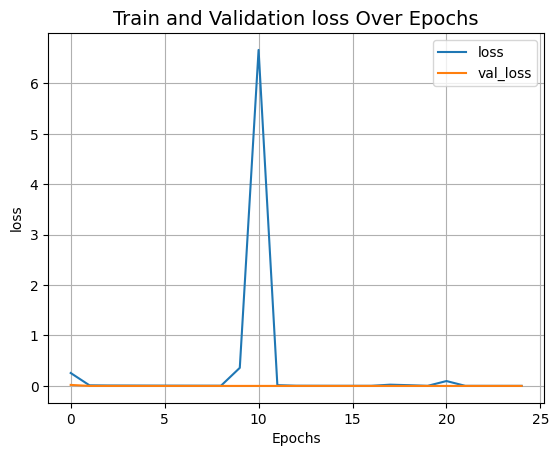

In [10]:
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

    checkpoint_filepath = "vit_object_detector.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[
            checkpoint_callback,
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
        ],
    )

    return history


input_shape = (image_size, image_size, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 25
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]


history = []
num_patches = (image_size // patch_size) ** 2

vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

history = run_experiment(
    vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs
)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
mean_iou: 0.9889197530864198


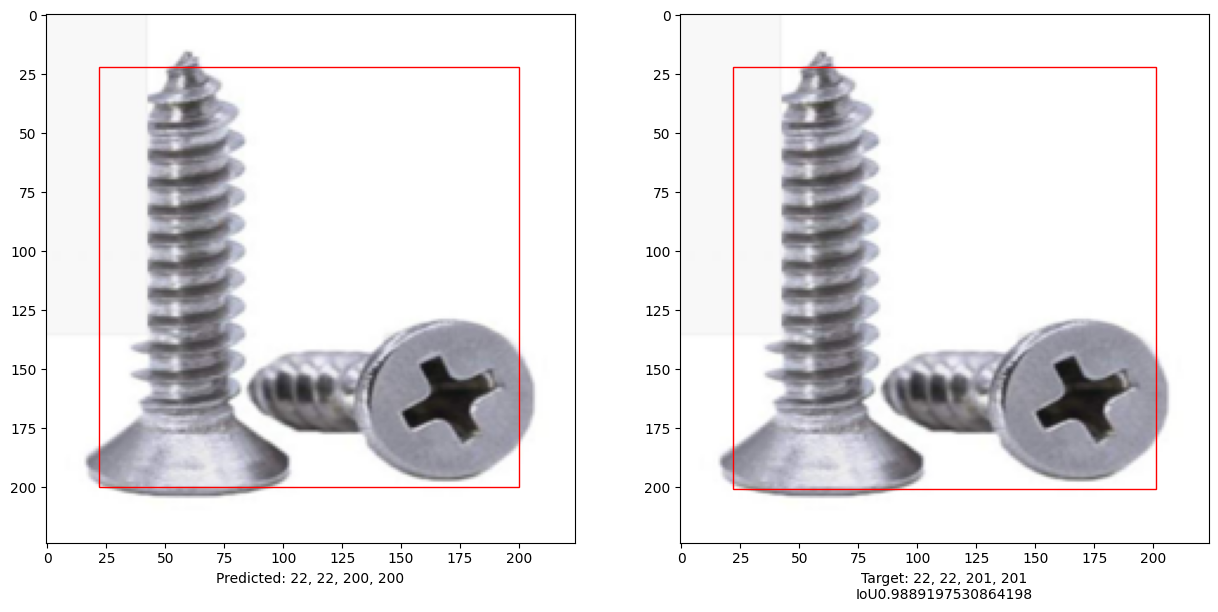

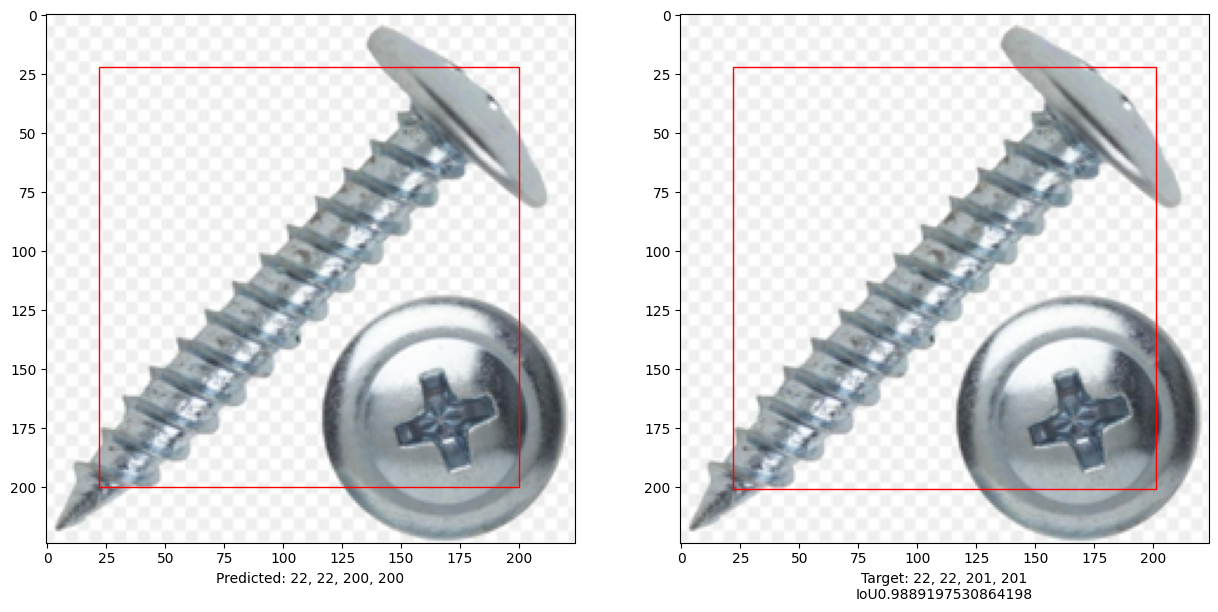

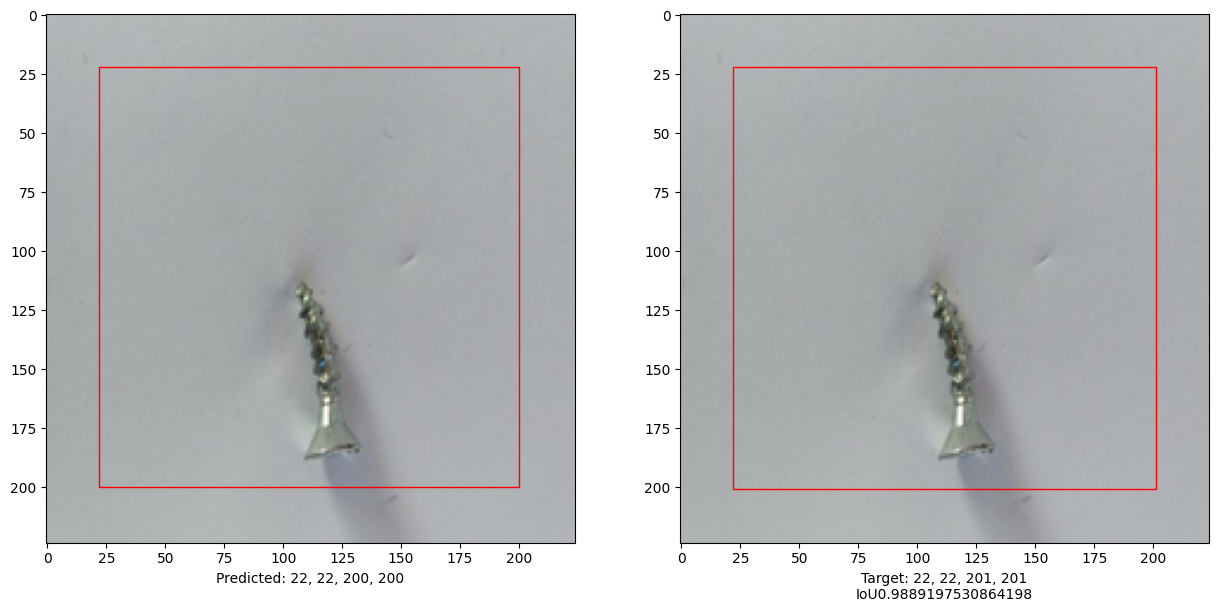

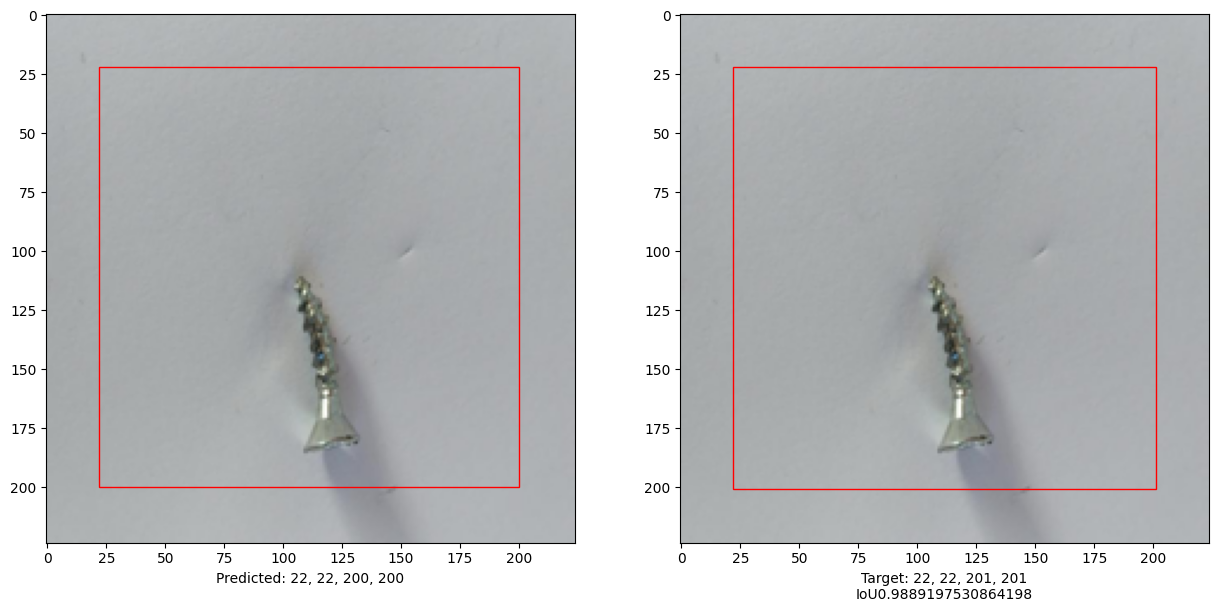

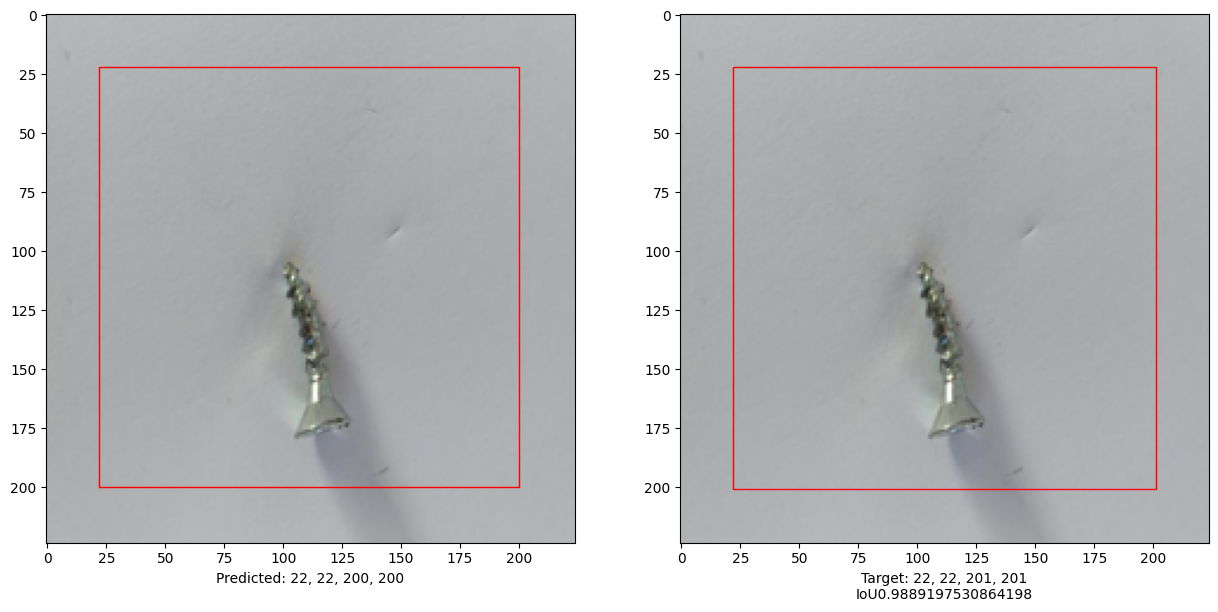

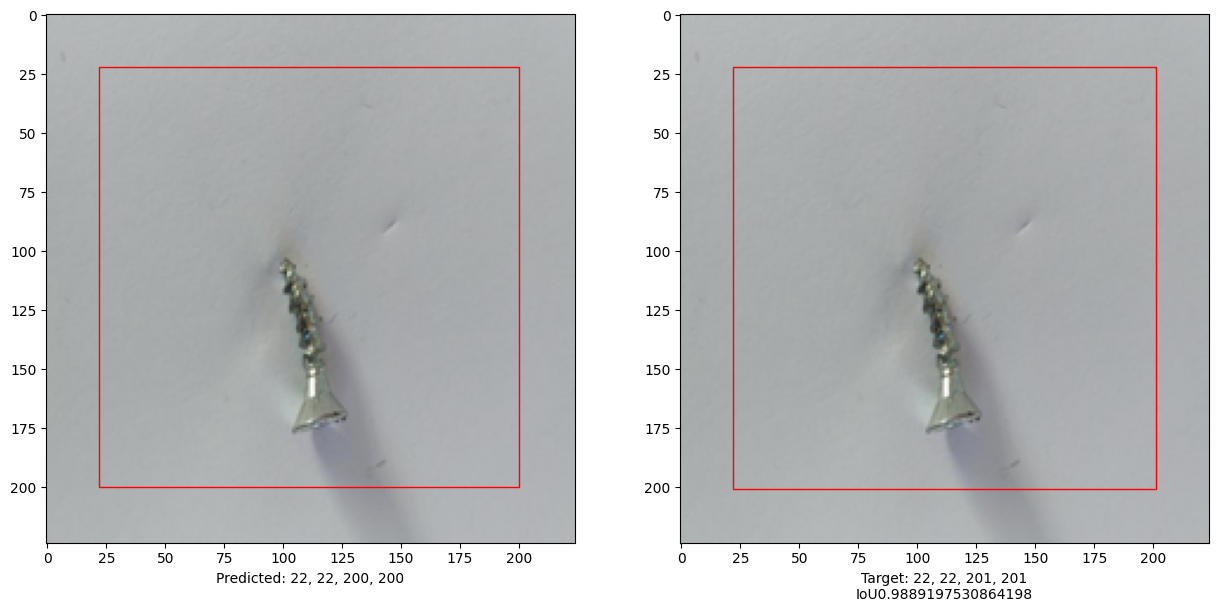

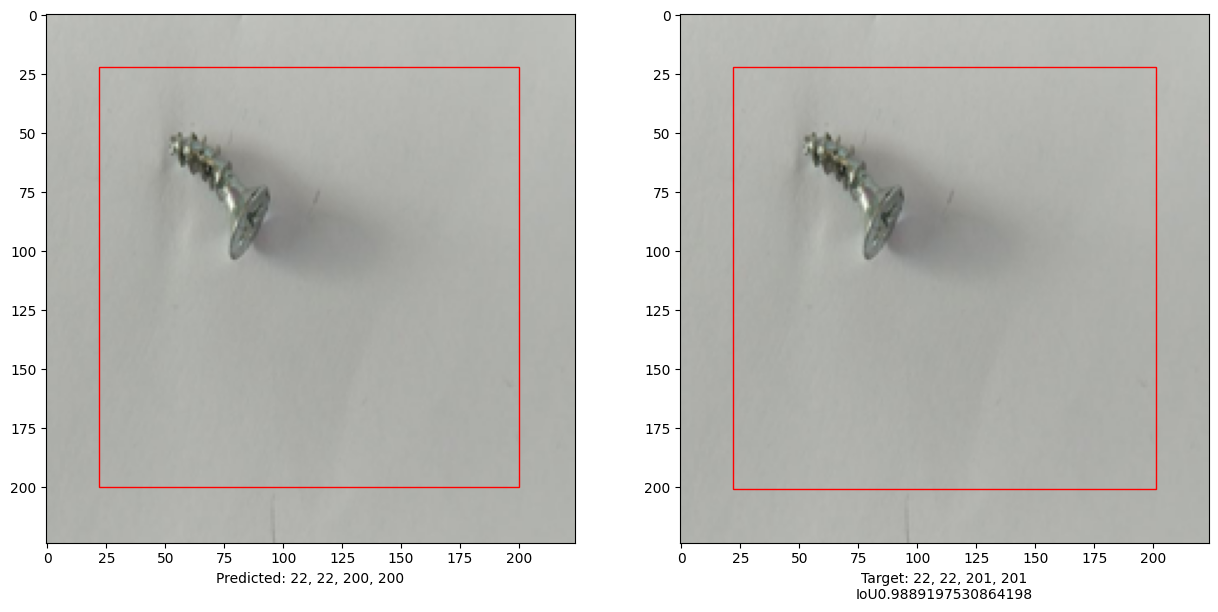

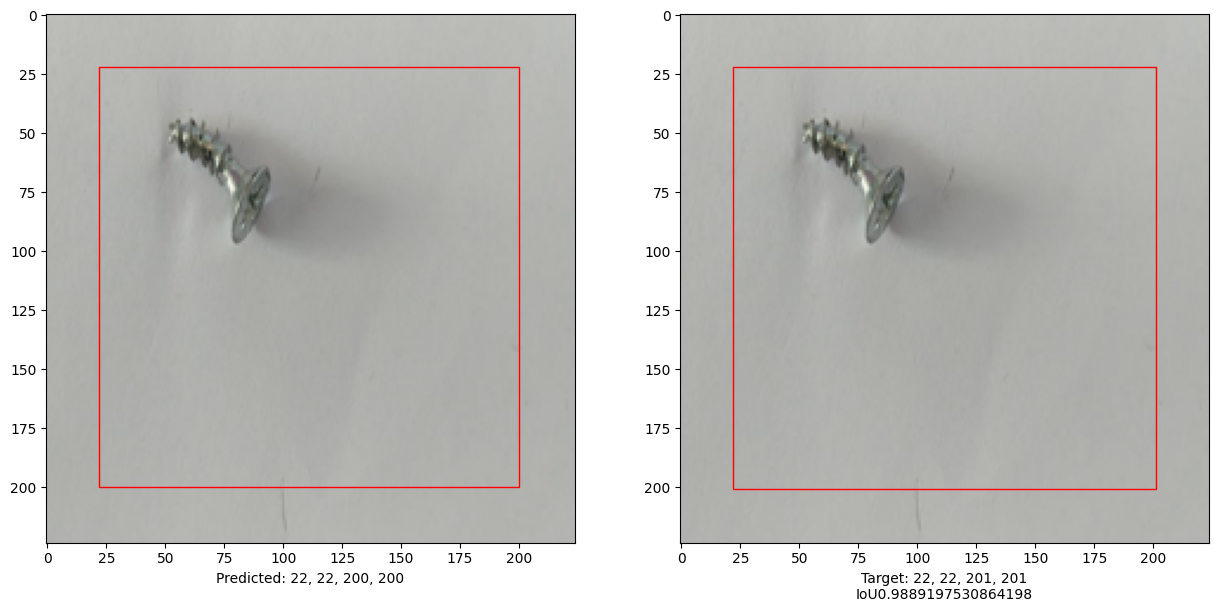

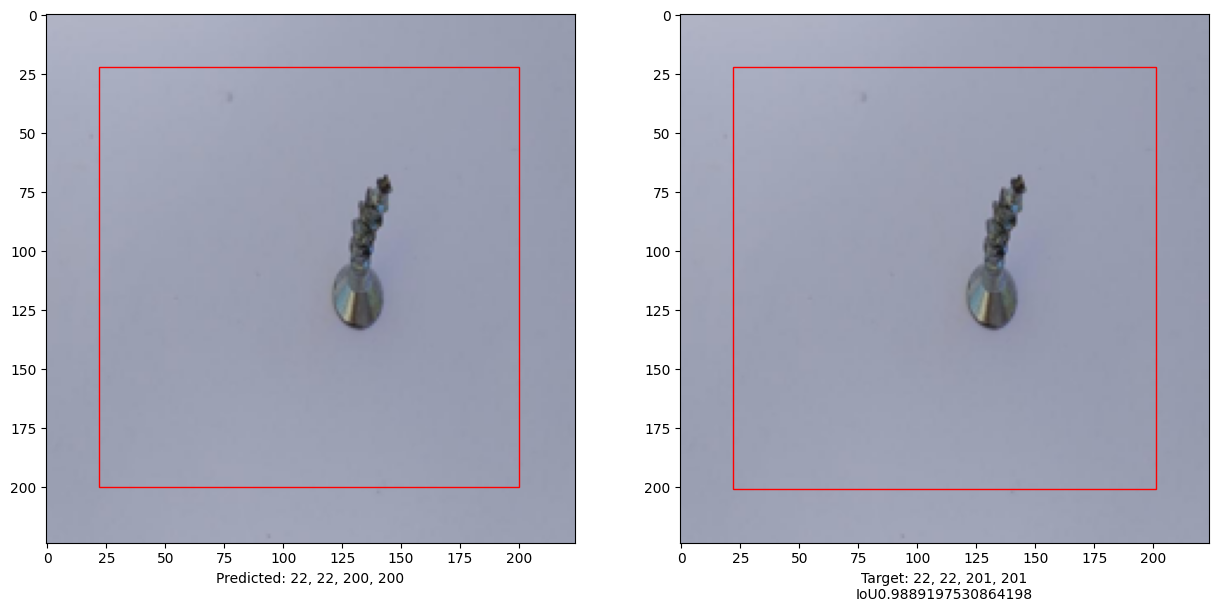

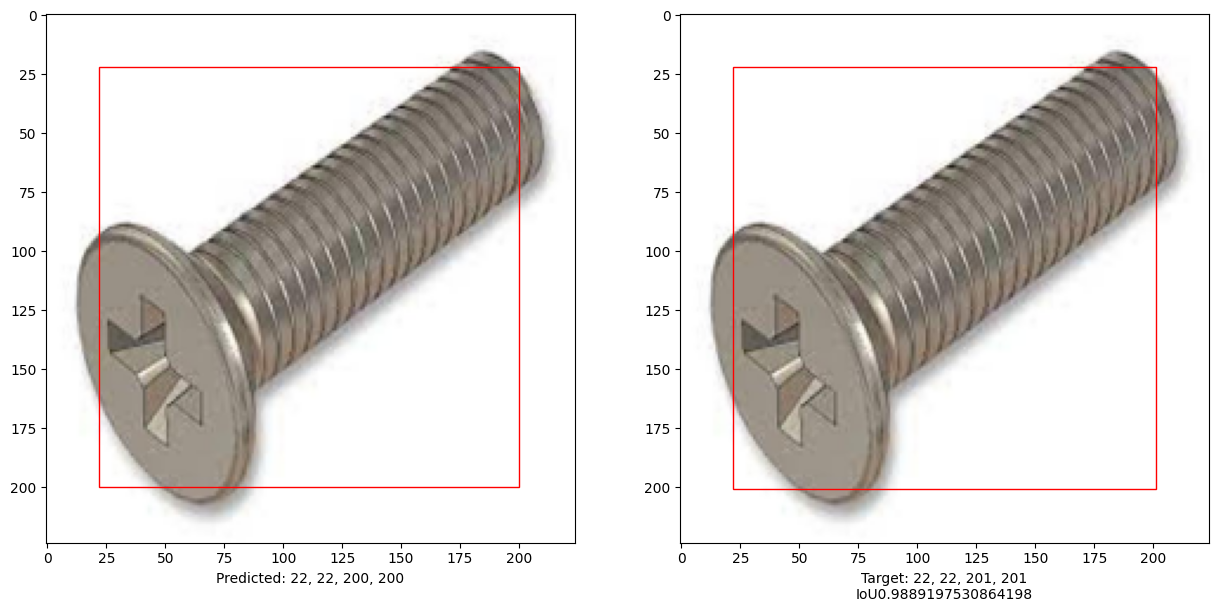

In [11]:
import matplotlib.patches as patches

vit_object_detector.save("vit_object_detector.keras")


def bounding_box_intersection_over_union(box_predicted, box_truth):
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )


i, mean_iou = 0, 0

for input_image in x_test[:10]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image

    ax1.imshow(im.astype("uint8"))
    ax2.imshow(im.astype("uint8"))

    input_image = cv2.resize(
        input_image, (image_size, image_size), interpolation=cv2.INTER_AREA
    )
    input_image = np.expand_dims(input_image, axis=0)
    preds = vit_object_detector.predict(input_image)[0]

    (h, w) = (im).shape[0:2]

    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    ax1.add_patch(rect)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )

    top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h)

    bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    ax2.add_patch(rect)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU"
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    i = i + 1

print("mean_iou: " + str(mean_iou / len(x_test[:10])))
plt.show()

# Menguji model dengan gambar-gambar custom dari Drive

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Mounted at /content/drive
Images loaded from Google Drive: 6
Mean Squared Error on Drive test data: 1.4827953236817848e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


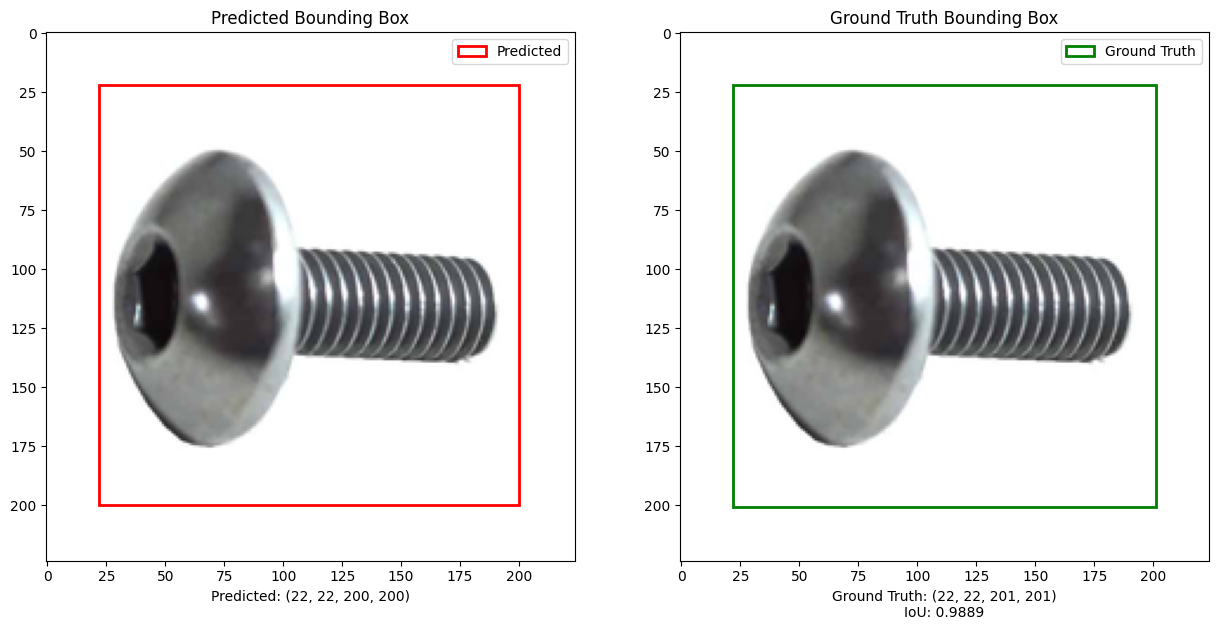

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


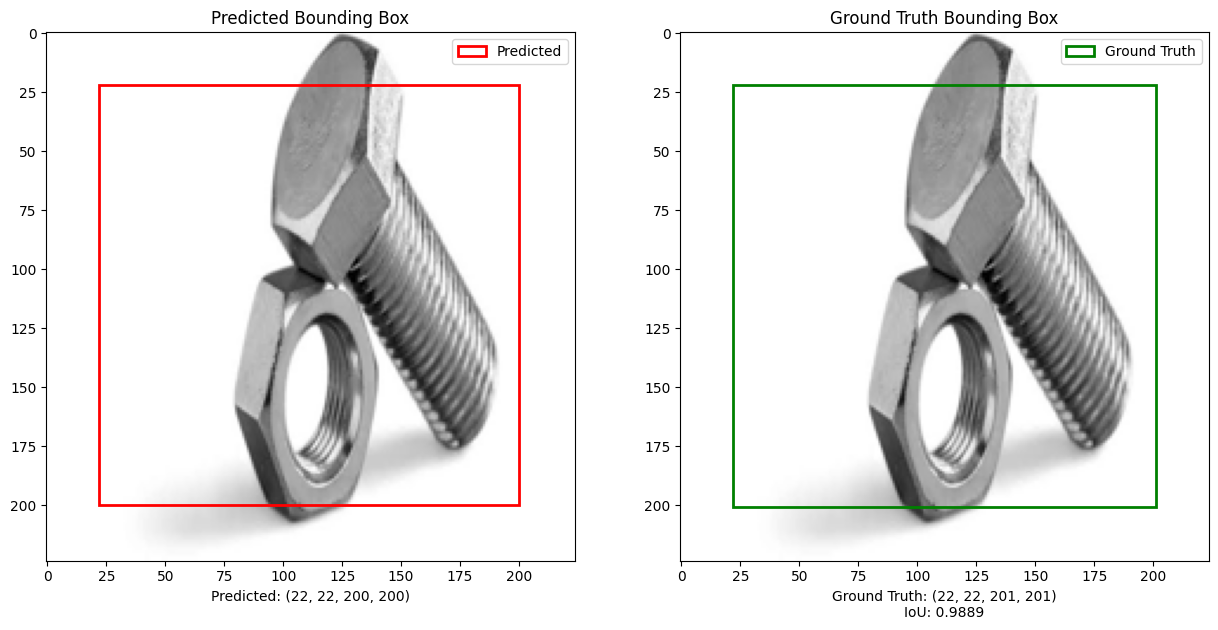

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


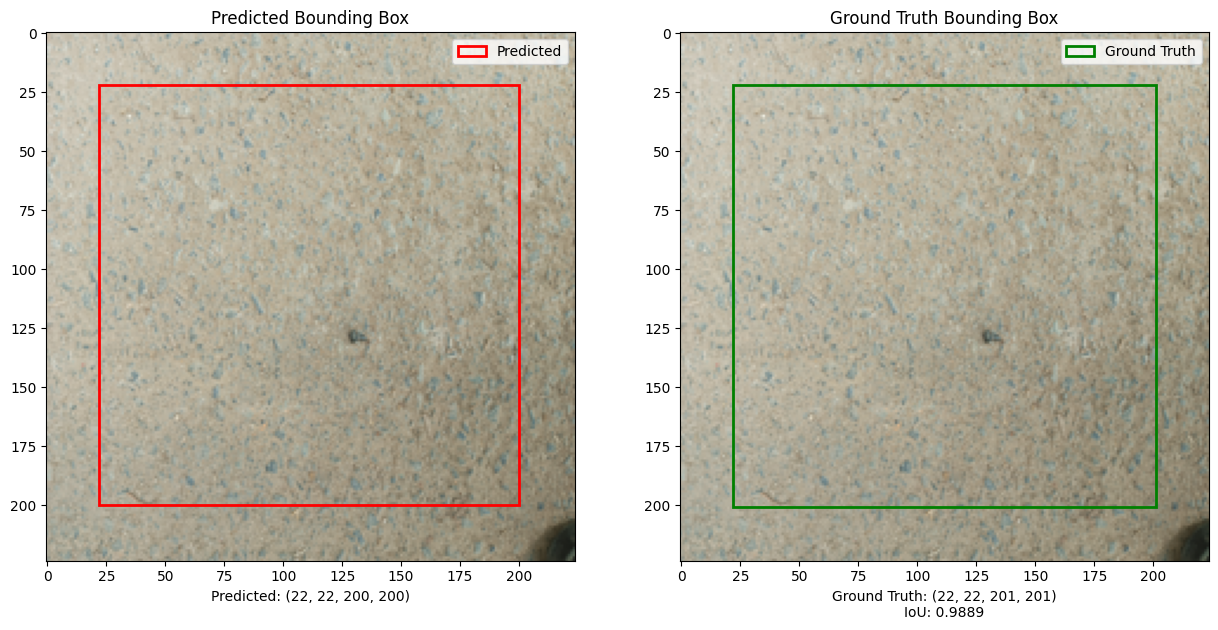

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


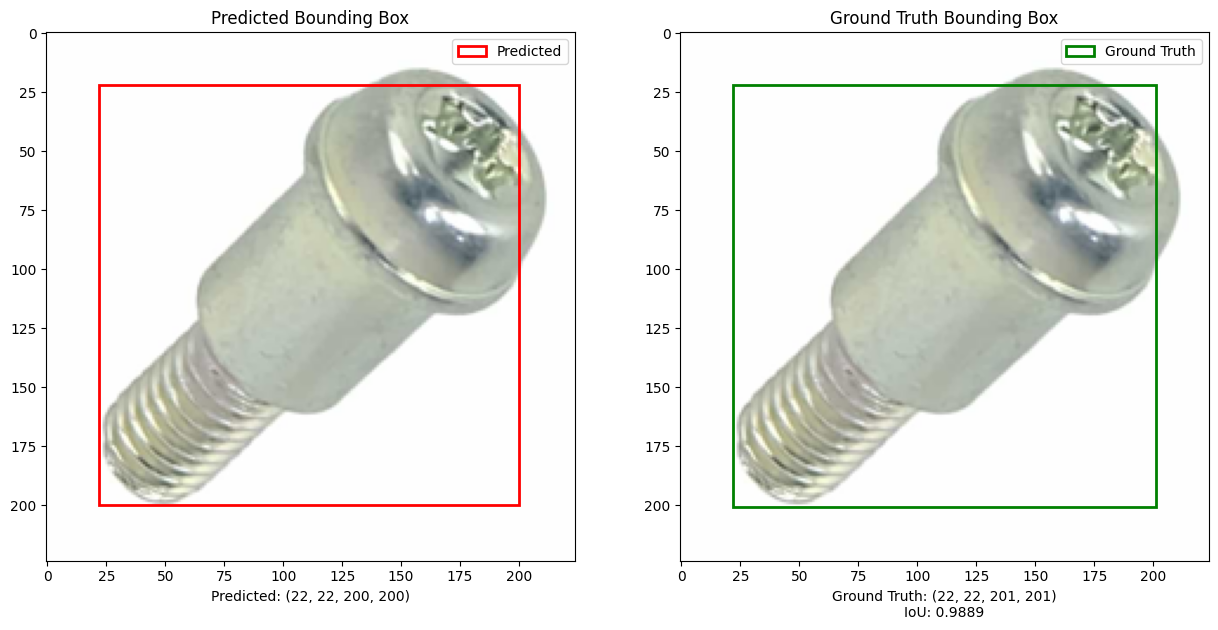

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


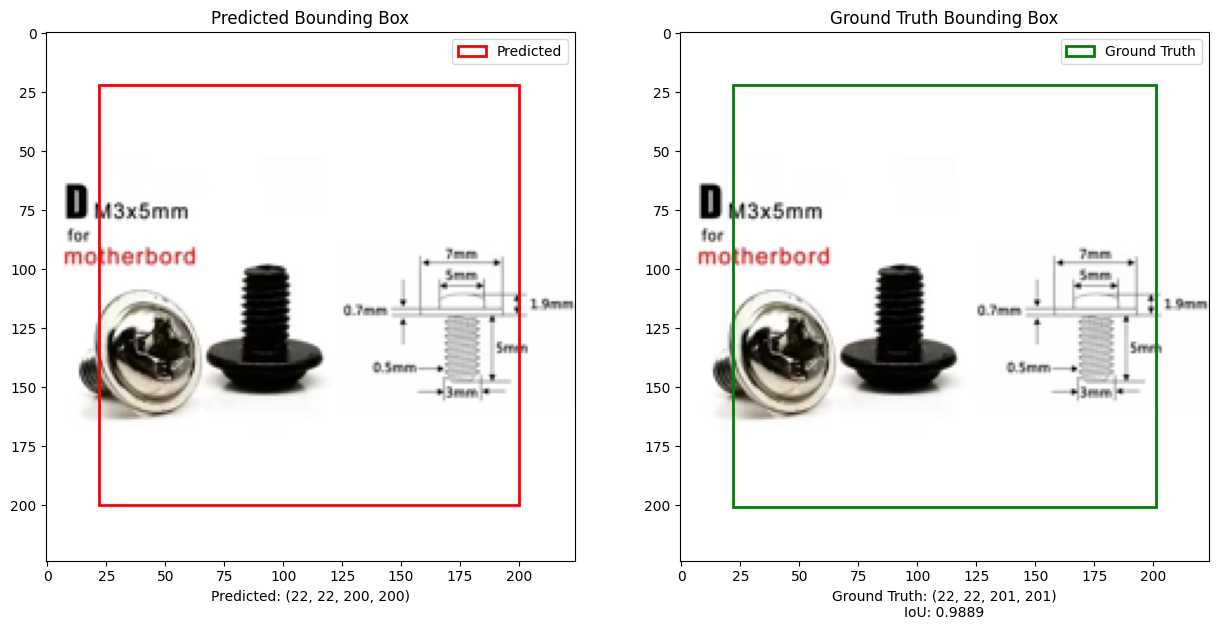

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


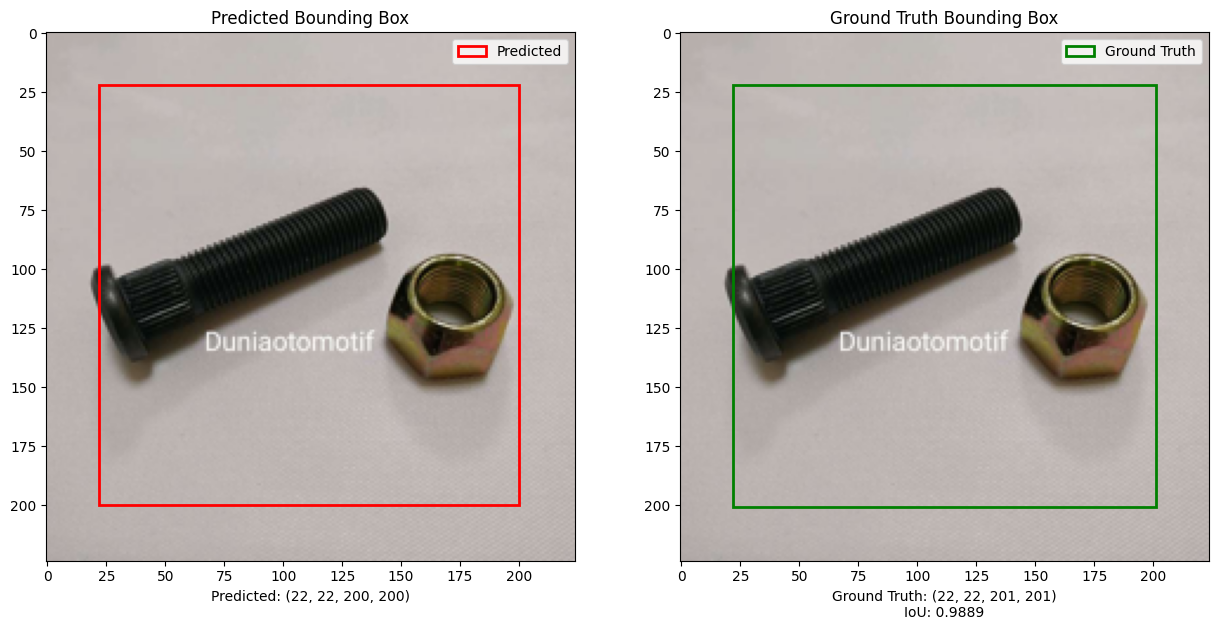

Mean IoU over 10 images: 0.5934


In [13]:
import matplotlib.pyplot as plt
import numpy as np
drive.mount('/content/drive', force_remount=True)

path_to_drive_test_images = "/content/drive/MyDrive/bauttes" #ubah ke "content/drive/MyDrive/test", dimanakah folder test berisi baut-baut berada

if not os.path.exists(path_to_drive_test_images):
    print(f"Error: Directory not found at {path_to_drive_test_images}")
else:
    x_drive_test, y_drive_test = load_dataset_from_directory(path_to_drive_test_images)

    print(f"Images loaded from Google Drive: {len(x_drive_test)}")

    evaluation_results = vit_object_detector.evaluate(x_drive_test, y_drive_test, verbose=0)
    print(f"Mean Squared Error on Drive test data: {evaluation_results}")

    i, mean_iou = 0, 0
    num_images_to_show = 10

    for input_image_original in x_drive_test[:num_images_to_show]:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
        im = input_image_original.astype("uint8")

        ax1.imshow(im)
        ax2.imshow(im)

        input_image_resized = cv2.resize(
            input_image_original, (image_size, image_size), interpolation=cv2.INTER_AREA
        )
        input_image_for_prediction = np.expand_dims(input_image_resized, axis=0)

        preds = vit_object_detector.predict(input_image_for_prediction)[0]

        (h, w) = im.shape[0:2]

        top_left_x_pred, top_left_y_pred = int(preds[0] * w), int(preds[1] * h)
        bottom_right_x_pred, bottom_right_y_pred = int(preds[2] * w), int(preds[3] * h)

        box_predicted = [top_left_x_pred, top_left_y_pred, bottom_right_x_pred, bottom_right_y_pred]

        rect_pred = patches.Rectangle(
            (top_left_x_pred, top_left_y_pred),
            bottom_right_x_pred - top_left_x_pred,
            bottom_right_y_pred - top_left_y_pred,
            facecolor="none",
            edgecolor="red",
            linewidth=2,
            label='Predicted'
        )
        ax1.add_patch(rect_pred)
        ax1.set_title("Predicted Bounding Box")
        ax1.set_xlabel(
            f"Predicted: ({top_left_x_pred}, {top_left_y_pred}, {bottom_right_x_pred}, {bottom_right_y_pred})"
        )
        ax1.legend()

        top_left_x_truth, top_left_y_truth = int(y_drive_test[i][0] * w), int(y_drive_test[i][1] * h)
        bottom_right_x_truth, bottom_right_y_truth = int(y_drive_test[i][2] * w), int(y_drive_test[i][3] * h)

        box_truth = [top_left_x_truth, top_left_y_truth, bottom_right_x_truth, bottom_right_y_truth]

        iou = bounding_box_intersection_over_union(box_predicted, box_truth)
        mean_iou += iou

        rect_truth = patches.Rectangle(
            (top_left_x_truth, top_left_y_truth),
            bottom_right_x_truth - top_left_x_truth,
            bottom_right_y_truth - top_left_y_truth,
            facecolor="none",
            edgecolor="green",
            linewidth=2,
            label='Ground Truth'
        )
        ax2.add_patch(rect_truth)
        ax2.set_title("Ground Truth Bounding Box")
        ax2.set_xlabel(
            f"Ground Truth: ({top_left_x_truth}, {top_left_y_truth}, {bottom_right_x_truth}, {bottom_right_y_truth})\nIoU: {iou:.4f}"
        )
        ax2.legend()

        plt.show()
        i += 1

    if num_images_to_show > 0:
        print(f"Mean IoU over {num_images_to_show} images: {mean_iou / num_images_to_show:.4f}")
    else:
        print("No images processed for IoU calculation.")

# Menyimpan model

In [ ]:
model.save("vit_baut3_final_model.keras")

#Save model drive
drive_model_path = "/content/drive/MyDrive/vit_caribaut3_model.h5"
model.save(drive_model_path)
print(f"Model saved to: {drive_model_path}")

# Membuat Demo/API interaktif dengan Gradio

In [15]:
!pip install gradio

In [16]:
import gradio as gr
import numpy as np
import cv2
import tensorflow as tf

model_path = "/content/drive/MyDrive/vit_caribaut3_model.h5"

custom_objects = {'Patches': Patches, 'PatchEncoder': PatchEncoder}

def predict_bounding_box(image):
    """
    Predicts the bounding box for an input image using the ViT model.

    Args:
        image: A PIL Image or numpy array (from Gradio).

    Returns:
        A tuple containing the annotated image (numpy array) and the predicted
        bounding box coordinates string.
    """
    if image is None:
        return None, "No image provided"

    if not isinstance(image, np.ndarray):
        image = np.array(image)

    original_h, original_w = image.shape[:2]

    image_resized = cv2.resize(image, (image_size, image_size), interpolation=cv2.INTER_AREA)
    input_image_for_prediction = np.expand_dims(image_resized, axis=0)

    input_image_for_prediction = input_image_for_prediction.astype(np.float32)

    try:
        preds = vit_object_detector.predict(input_image_for_prediction)[0]
    except Exception as e:
        return image, f"Prediction Error: {e}"

    top_left_x_pred = int(preds[0] * original_w)
    top_left_y_pred = int(preds[1] * original_h)
    bottom_right_x_pred = int(preds[2] * original_w)
    bottom_right_y_pred = int(preds[3] * original_h)

    top_left_x_pred = max(0, top_left_x_pred)
    top_left_y_pred = max(0, top_left_y_pred)
    bottom_right_x_pred = min(original_w - 1, bottom_right_x_pred)
    bottom_right_y_pred = min(original_h - 1, bottom_right_y_pred)

    image_with_bbox = image.copy()
    cv2.rectangle(image_with_bbox, (top_left_x_pred, top_left_y_pred), (bottom_right_x_pred, bottom_right_y_pred), (255, 0, 0), 2) # Red color, thickness 2

    text = f"Predicted: ({top_left_x_pred}, {top_left_y_pred}, {bottom_right_x_pred}, {bottom_right_y_pred})"
    cv2.putText(image_with_bbox, text, (top_left_x_pred, top_left_y_pred - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    predicted_coords_str = f"Predicted BBox: x_min={top_left_x_pred}, y_min={top_left_y_pred}, x_max={bottom_right_x_pred}, y_max={bottom_right_y_pred}"

    return image_with_bbox, predicted_coords_str

iface = gr.Interface(
    fn=predict_bounding_box,
    inputs=gr.Image(type="numpy", label="Upload an Image"),
    outputs=[
        gr.Image(type="numpy", label="Image with Predicted Bounding Box"),
        gr.Textbox(label="Predicted Bounding Box Coordinates")
        ],
    title="ViT Object Detector Demo",
    description="Upload an image to get the predicted bounding box using a Vision Transformer model."
)

iface.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://4ede558de8b247ee55.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://4ede558de8b247ee55.gradio.live
